# Imports

In [1]:
import os

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn.feature_extraction.text
import sklearn.feature_selection
import sklearn.linear_model

import sklearn.metrics

import sklearn.model_selection
import sklearn.pipeline


from IPython.display import display

# Parameters

In [2]:
data_dirname = "../SMS-Spam"
data_basename = "data.csv.gz"

# Helper Functions

In [3]:
def evaluate_classifier(classifier, X_train, X_test, y_train, y_test):
    cv_results = sklearn.model_selection.cross_validate(
        classifier,
        X_train,
        y_train,
        cv=10,
        scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
        return_train_score=True,
    )
    
    results_dict = dict()
    for key,value in cv_results.items():
        tokens = key.split("_")
        if tokens[0] in ["train", "test"]:
            results_dict.setdefault(
                tokens[0], dict()
            )["_".join(tokens[1:])] = np.mean(value)
    print(classifier)
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(
            pd.DataFrame(results_dict)
        )

# Data Loading

In [4]:
filename = os.path.join(data_dirname, data_basename)
raw_df = pd.read_csv(filename, compression="gzip").dropna()

raw_df.info(verbose=True)
with pd.option_context("display.max_rows", 10, "display.max_columns", None, "display.max_colwidth", None):
    display(
        raw_df
    )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   spam    5572 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 92.5+ KB


,text,spam
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",False
1,Ok lar... Joking wif u oni...,False
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,True
3,U dun say so early hor... U c already then say...,False
4,"Nah I don't think he goes to usf, he lives around here though",False
...,...,...
5567,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",True
5568,Will Ì_ b going to esplanade fr home?,False
5569,"Pity, * was in mood for that. So...any other suggestions?",False
5570,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,False


# Train-Test Split

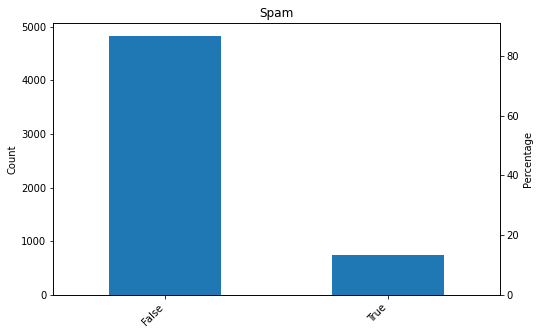

In [5]:
count_df = raw_df["spam"].value_counts()
percent_df = raw_df["spam"].value_counts(normalize=True).mul(100)

fig,ax = plt.subplots(figsize=(8,5))
count_df.plot(kind="bar", ax=ax)
ax.set_xticklabels(count_df.index, rotation=45, ha="right")
ax.set_ylabel("Count")
ax = ax.twinx()
percent_df.plot(kind="bar", ax=ax)
ax.set_ylabel("Percentage")
ax.set_title("Spam")
plt.show()

XX = raw_df["text"].values
yy = raw_df["spam"].values

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    XX,
    yy,
    stratify=yy,
    random_state=0
)

# The CountVectorizer

The [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) can be used to convert a collection of text documents into a [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix). The rows of a document-term matrix represent documents (samples), while the columns represent terms (features). The $a_{i,j}$ entry in a document-term matrix represents the frequence of term $j$ in document $i$. The terms, which are single words or sequences of words (i.e., [n-grams](https://en.wikipedia.org/wiki/N-gram)),  can either be learned from the training data or provided in the `CountVectorizer`'s constructor through the `vocabulary` parameter.

Let's use the `CountVectorizer` to learn a vocabulary dictionary of all tokens in the raw documents.

In [6]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer(lowercase=False)
count_vectorizer.fit(X_train)
vocabulary = np.asarray(count_vectorizer.get_feature_names())

print(f"{len(vocabulary)} vocabulary terms extracted")
print(vocabulary)

9226 vocabulary terms extracted
['00' '000' '000pes' ... 'åÒIt' 'åÔMORROW' 'åÔrents']


The [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform) method is used to extract token counts from raw text documents using the fitted vocabulary. It returns a sparse matrix, which can be converted to a [`numpy.ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) using the `toarray` method.

Let’s find the top 10 words appearing most frequently in the training data and display some summary statistics about them.

,to,you,the,and,in,is,me,my,for,it
Min.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Max.,8.000000,11.000000,7.000000,3.000000,3.000000,5.000000,5.000000,5.000000,5.000000,12.000000
Mean,0.385499,0.327830,0.213209,0.159608,0.147404,0.146686,0.136396,0.116056,0.115578,0.107921
S.D.,0.703113,0.724057,0.522989,0.444191,0.397768,0.429550,0.407590,0.395207,0.368403,0.416324


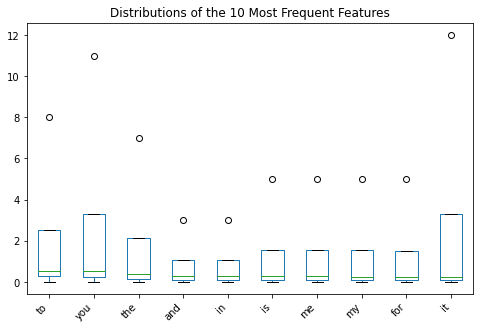

In [7]:
doc_term_matrix = count_vectorizer.transform(X_train).toarray()

frequencies = doc_term_matrix.sum(axis=0)
idx = np.argsort(-frequencies)[:10]

vmin = doc_term_matrix.min(axis=0)
vmax = doc_term_matrix.max(axis=0)
mean = doc_term_matrix.mean(axis=0)
std = doc_term_matrix.std(axis=0)

stats_df = pd.DataFrame(
    [vmin, vmax, mean, std],
    columns=vocabulary,
    index=["Min.", "Max.", "Mean", "S.D."]
)
with pd.option_context("display.max_rows", None, "display.max_columns", 20):
    display(stats_df[vocabulary[idx]])

fig,ax = plt.subplots(figsize=(8,5))
stats_df[vocabulary[idx]].boxplot(ax=ax)
ax.set_xticklabels(vocabulary[idx], rotation=45, ha="right")
ax.grid(False)
ax.set_title(f"Distributions of the {len(idx)} Most Frequent Features")
plt.show()

# Feature Selection

The `CountVectorizer` produces a lot of features, especially when n-grams are extracted. Many of the features do not provide very much information, such as the top ten features seen above, and too many features can cause our model to overfit. We can use a chi-square test to determine how strong the dependency is between the various features and the target class. By leveraging the [`SelectKBest`](sklearn.feature_selection.SelectKBest) class, we can select the top $k$ features according to the chi-square test statistic.

Let's find the top 10 features, according to the chi-square test, using `SelectKBest`. 

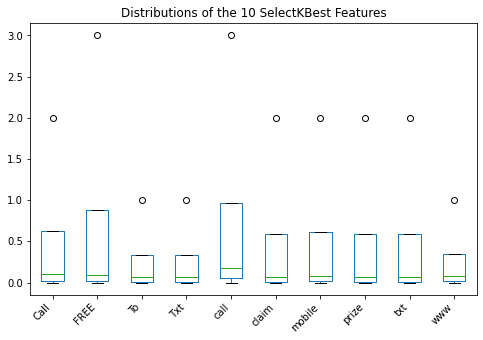

In [8]:
select_k_best = sklearn.feature_selection.SelectKBest(
    sklearn.feature_selection.chi2,
    k=10
)
select_k_best.fit(doc_term_matrix, y_train)
idx, = np.where( select_k_best.get_support() )

fig,ax = plt.subplots(figsize=(8,5))
stats_df[vocabulary[idx]].boxplot(ax=ax)
ax.set_xticklabels(vocabulary[idx], rotation=45, ha="right")
ax.grid(False)
ax.set_title(f"Distributions of the {len(idx)} SelectKBest Features")
plt.show()

# Models

We want to create a predictive model for detecting spam using [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). By leveraging [`Piplelines`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and the [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) function, we can combine the `CountVectorizer` and `SelectKBest` transformers, along with the `LogisticRegression` classifier, into a single model.

## Model 1

Our basic model will consist of just a `CountVectorizer` transformer fed into the `LogisticRegression` classifier. We set the `lowercase=False` so that the `CountVectorizer` operates on the raw text.

In [9]:
classifier = sklearn.pipeline.make_pipeline(
    sklearn.feature_extraction.text.CountVectorizer(lowercase=False),
    sklearn.linear_model.LogisticRegression()
)
evaluate_classifier(classifier, X_train, X_test, y_train, y_test)

Pipeline(steps=[('countvectorizer', CountVectorizer(lowercase=False)),
                ('logisticregression', LogisticRegression())])


,test,train
accuracy,0.979422,0.998617
precision,0.985946,1.000000
recall,0.858929,0.989683
f1,0.917404,0.994814
roc_auc,0.991446,0.999869


## Model 2

For our second model, we will use the `CountVectorizer` to extract single word terms, as well as bigrams and trigrams.

In [10]:
classifier = sklearn.pipeline.make_pipeline(
    sklearn.feature_extraction.text.CountVectorizer(
        lowercase=False,
        ngram_range=(1,3)
    ),
    sklearn.linear_model.LogisticRegression()
)
evaluate_classifier(classifier, X_train, X_test, y_train, y_test)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(lowercase=False, ngram_range=(1, 3))),
                ('logisticregression', LogisticRegression())])


,test,train
accuracy,0.975116,0.999521
precision,0.998000,1.000000
recall,0.816071,0.996429
f1,0.896778,0.998211
roc_auc,0.990414,0.999945


## Model 3

Our next model will include the `SelectKBest` transformer to extract the top 100 features (i.e., words, bigrams, and trigrams) according to the chi-square test statistic.

In [11]:
classifier = sklearn.pipeline.make_pipeline(
    sklearn.feature_extraction.text.CountVectorizer(
        lowercase=False,
        ngram_range=(1,3)
    ),
    sklearn.feature_selection.SelectKBest(
        sklearn.feature_selection.chi2,
        k=100
    ),
    sklearn.linear_model.LogisticRegression()
)
evaluate_classifier(classifier, X_train, X_test, y_train, y_test)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(lowercase=False, ngram_range=(1, 3))),
                ('selectkbest',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x2aaaf149d268>)),
                ('logisticregression', LogisticRegression())])


,test,train
accuracy,0.971284,0.976549
precision,0.969803,0.973358
recall,0.812500,0.848214
f1,0.883229,0.906472
roc_auc,0.976611,0.980393


## Model 4

Our final model will employ some natural language processing to clean the text before extracting terms for the document-term matrix. We will allow the `CountVectorizer` to transform the text to lowercase. We will also use the [WordNetLemmatizer](https://www.nltk.org/_modules/nltk/stem/wordnet.html) to perform [lemmatization](https://en.wikipedia.org/wiki/Lemmatisation) on the text (i.e., converting `change`, `changing`, `changes`, `changed`, and `changer` all to `change`).

First we need to setup nltk...

In [12]:
import nltk
import nltk.stem
nltk.data.path.append("../nltk_data")

try:
    nltk.data.find("tokenizers/punkt")
except LookupError as le:
    nltk.download("punkt", download_dir="../nltk_data")
    
try:
    nltk.data.find("corpora/wordnet")
except LookupError as le:
    nltk.download("wordnet", download_dir="../nltk_data")
    
try:
    nltk.data.find("corpora/omw-1.4")
except LookupError as le:
    nltk.download("omw-1.4", download_dir="../nltk_data")

[nltk_data] Downloading package punkt to ../nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to ../nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to ../nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Now we can build our model.

In [13]:
class LemmaTokenizer(object):
    def __init__(self):
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
    def __call__(self, text):
        return [
            self.lemmatizer.lemmatize(word)
            for word in nltk.word_tokenize(text)
        ]
    
classifier = sklearn.pipeline.make_pipeline(
    sklearn.feature_extraction.text.CountVectorizer(
        tokenizer=LemmaTokenizer(),
        lowercase=True,
        ngram_range=(1,3)
    ),
    sklearn.feature_selection.SelectKBest(
        sklearn.feature_selection.chi2,
        k=100
    ),
    sklearn.linear_model.LogisticRegression()
)
evaluate_classifier(classifier, X_train, X_test, y_train, y_test)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<__main__.LemmaTokenizer object at 0x2aaaf49cf668>)),
                ('selectkbest',
                 SelectKBest(k=100,
                             score_func=<function chi2 at 0x2aaaf149d268>)),
                ('logisticregression', LogisticRegression())])


,test,train
accuracy,0.968412,0.976576
precision,0.947506,0.960381
recall,0.810714,0.860714
f1,0.872347,0.907806
roc_auc,0.979562,0.984663
